In [1]:
import os
from collections import Counter

import sklearn.cluster
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from six import iteritems

import gensim
from fuzzywuzzy import fuzz, process
from Litho.nlp_funcs import *
from Litho.similarity import (check_similarity, match_lithcode, jaccard_similarity, 
                              calc_similarity_score, print_sim_compare)
from tqdm import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

path = 'example_data'
lith_data = 'sampled_bores.csv'
path_to_data = os.path.join(path, lith_data)

lith_df = pd.read_csv(path_to_data, index_col='HydroCode')

C:\UserData\takuyai\Miniconda3\envs\lith_nlp\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


I've modified and moved out the functions defined in the example script, which are imported below.

In [2]:
path = 'example_data'
lith_data = 'sampled_bores.csv'
path_to_data = os.path.join(path, lith_data)

lith_df = pd.read_csv(path_to_data, index_col='HydroCode')

In [3]:
lith_df.loc[:, ['MajorLithCode', 'Description']].head()

,MajorLithCode,Description
HydroCode,,
GW036600.1.1,GRVL,Gravel cemented water bearing
GW030378.3.1,CLAY,"Clay; brown and buff grey, fine to coarse sand..."
GW900892.1.1,UNKN,Pink volcanic clay
GW902811.1.1,CRSE,Coarse gravel rocks and clay
GW967721.1.1,SHLE,Shale


We could use the MajorLithCode to inform our clustering (minor appears to be always empty). 

Unfortunately, there are 99 entries in the example set with unknown or numerical values (as shown below)

In [4]:
is_unknown_or_numeric = (lith_df.MajorLithCode == 'UNKN') | lith_df.MajorLithCode.str.isnumeric()
lith_df.loc[is_unknown_or_numeric, 'MajorLithCode'].count()

99

In [5]:
lith_df.loc[is_unknown_or_numeric, ['BoreID', 'MajorLithCode', 'Description']].head(10)

,BoreID,MajorLithCode,Description
HydroCode,,,
GW900892.1.1,10144626,UNKN,Pink volcanic clay
GW901825.1.1,10145558,UNKN,Sandy clay
GW900653.1.1,10144387,UNKN,Black soil
GW900329.1.1,10144063,UNKN,Soft basalt
GW900449.1.1,10144183,UNKN,Brown clay
GW900748.1.1,10144482,UNKN,Sand and gravel
GW965568.1.1,10147134,19,Silty clay brown with white flakes
GW902177.1.1,10145907,UNKN,Softer brown & grey clay
GW900968.1.1,10144702,UNKN,Brown clay with pebbles


In [6]:
print(len(lith_df.loc[~is_unknown_or_numeric, 'MajorLithCode'].unique()), "Unique LithCodes that are not UNKN or numeric")
print(lith_df.loc[~is_unknown_or_numeric, 'MajorLithCode'].unique())

41 Unique LithCodes that are not UNKN or numeric
['GRVL' 'CLAY' 'CRSE' 'SHLE' 'BSLT' 'ROCK' 'SAND' 'SOIL' 'GRNT' 'SASH'
 'CGLM' 'SDSN' 'TPSL' 'BLBN' 'COAL' 'SILT' 'LMSN' 'ALVM' 'QRTZ' 'SDCY'
 'LOAM' 'BLDR' 'SLTE' 'SLCY' 'BNST' 'VLCC' 'SLSN' 'BRBN' 'GRBN' 'MDSN'
 'WB' 'TUFF' 'BDRK' 'SNDY' 'SDMN' 'CVTY' 'CLBD' 'FILL' 'DLMT' 'WODY'
 'FINE']


For each unknown entry, can we find a comparable entry with the same terminology in the description?

In [7]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed
stopw2 = ['redish', 'reddish', 'red', 'black', 'blackish', 'brown', 'brownish',
          'blue', 'blueish', 'orange', 'orangeish', 'gray', 'grey', 'grayish',
          'greyish', 'white', 'whiteish', 'purple', 'purpleish', 'yellow',
          'yellowish', 'green', 'greenish', 'light', 'very', 'pink','coarse',
          'fine', 'medium', 'hard', 'soft', 'coloured', 'multicoloured',
          'weathered', 'fractured']

stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(stopw2)  # add the additional stopwords above

In [8]:
subset = lith_df.loc[is_unknown_or_numeric, 'Description'].values 

print("Attempting to fill in {} unknown MajorLithCode based on provided descriptions".format(len(subset)))
unkn_cache = {}
for i in tqdm(subset):
    
    if i not in unkn_cache:
        tmp_df = lith_df.loc[~is_unknown_or_numeric, ['Description', 'MajorLithCode']]
        matches = tmp_df.apply(match_lithcode, args=(i, stopw2, ), axis=1)
        counts = Counter(matches.dropna().values)
        
        try:
            lith_code, num_occur = counts.most_common()[0]
            if num_occur < 3:
                raise IndexError  # Not enough to match lith code
        except IndexError:
            continue  # Could not find any matches!
        # End try

        # print(i, f' -> {lith_code} ({num_occur})')
        unkn_cache[i] = lith_code
    else:
        lith_code = unkn_cache[i]
    # End if
    
    lith_df.at[lith_df.Description == i, 'MajorLithCode'] = lith_code  # update lith code
# End for

Attempting to fill in 99 unknown MajorLithCode based on provided descriptions


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:32<00:00,  3.00it/s]


In [9]:
is_unknown_or_numeric = (lith_df.MajorLithCode == 'UNKN') | lith_df.MajorLithCode.str.isnumeric()
print("After clean up", len(lith_df.loc[~is_unknown_or_numeric, 'MajorLithCode'].unique()), "unique LithCodes that are not UNKN or numeric")
print(lith_df.loc[~is_unknown_or_numeric, 'MajorLithCode'].unique())

After clean up 40 unique LithCodes that are not UNKN or numeric
['GRVL' 'CLAY' 'CRSE' 'SHLE' 'BSLT' 'ROCK' 'SAND' 'SOIL' 'TPSL' 'GRNT'
 'SASH' 'CGLM' 'SDSN' 'COAL' 'SILT' 'LMSN' 'ALVM' 'QRTZ' 'SDCY' 'LOAM'
 'BLDR' 'SLTE' 'SLCY' 'VLCC' 'SLSN' 'BRBN' 'GRBN' 'MDSN' 'WB' 'TUFF'
 'BDRK' 'SNDY' 'SDMN' 'CVTY' 'CLBD' 'FILL' 'DLMT' 'WODY' 'BNST' 'FINE']


In [10]:
totalvocab_stemmed = []
totalvocab_tokenized = []

lith_code_desc = lith_df.loc[:, ['MajorLithCode', 'Description']]
# Filter to unique combinations of LithCode and Description
# lith_code_desc = lith_code_desc.groupby(['MajorLithCode','Description']).size().reset_index().rename(columns={0: 'count'})
for row in lith_code_desc.itertuples():
    # print(row.MajorLithCode, row.Description)
    #combined = "{} {}".format(row.MajorLithCode, row.Description) 
    allwords_stemmed = tokenize_and_stem(row.Description, stopwords) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend([allwords_stemmed]) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(row.Description, stopwords)
    totalvocab_tokenized.extend([allwords_tokenized])

In [11]:
print(np.shape(totalvocab_tokenized),  np.shape(totalvocab_stemmed))

(1000,) (1000,)


In [12]:
lith_code_desc.head()

,MajorLithCode,Description
HydroCode,,
GW036600.1.1,GRVL,Gravel cemented water bearing
GW030378.3.1,CLAY,"Clay; brown and buff grey, fine to coarse sand..."
GW900892.1.1,CLAY,Pink volcanic clay
GW902811.1.1,CRSE,Coarse gravel rocks and clay
GW967721.1.1,SHLE,Shale


In [13]:
## used gensim instead of cosdisimilarity from sklearn due to the huge distance matrix
dictionary = gensim.corpora.Dictionary(totalvocab_stemmed)
once_ids = [tokenid for tokenid, docfreq in iteritems(dictionary.dfs) if docfreq == 1]
dictionary.filter_tokens(once_ids)
dictionary.compactify()
print(dictionary)
# dictionary.save(path+'/dictio.dict')
# store the dictionary, for future reference

Dictionary(139 unique tokens: ['bear', 'cement', 'gravel', 'water', 'clay']...)


In [14]:
corpus = [dictionary.doc2bow(text) for text in totalvocab_stemmed]
corpus[:10]

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1), (5, 1), (6, 1), (7, 1), (8, 1)],
 [(4, 1), (9, 1)],
 [(2, 1), (4, 1), (5, 1), (10, 1)],
 [(11, 1)],
 [(12, 1)],
 [(10, 1)],
 [(4, 1)],
 [(0, 1), (3, 1), (11, 1)],
 [(0, 1), (3, 1), (10, 1), (13, 1)]]

In [15]:
# gensim.corpora.MmCorpus.serialize(path+'corpus.mm', corpus)  # store to disk, for later use
tf_idf = gensim.models.TfidfModel(corpus)
sims = gensim.similarities.Similarity(path, tf_idf[corpus],
                                      num_features=len(dictionary))

x, y = [], []
for n, i in enumerate(corpus[0:50]):
    dist = 1-sims[tf_idf[i]]
    # print(dist, len(dist))
    if i == 0:
        x0, y0 = 0, 0
    elif i == 1:
        x0, y0 = 0, dist[0]
    else:
        dp1p2 = dist[0] + dist[1]
        dp1pn = dp1p2 + dist[1]
        dp2pn = dist[0] + dp1p2
        A = (dp1p2**2 + dp1pn**2 - dp2pn**2)/(2*dp1p2*dp1pn)
        x0, y0 = dp1pn*np.cos(A), dp1pn*np.sin(A)
    x.append(x0)
    y.append(y0)
# End for

Problem Statement:

The problem seems that as we are converting to a 2D plane, and using the first two descriptions as references ('sand' and 'clay'), in the plane different categories are being plotted at the same location and distance from these descriptions. Other issue is that it doesn't differentiate by the order in the description. Thus, sandy clay is plotted at the same location that clayey sand...

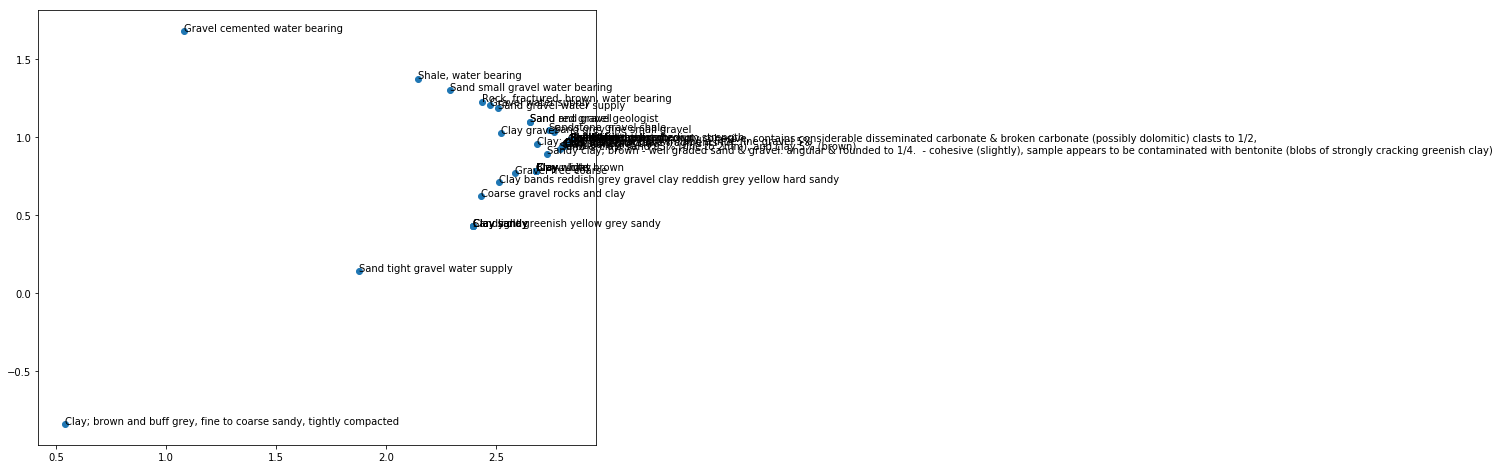

In [16]:
%matplotlib inline

lith_code_desc = lith_df.loc[:, ['MajorLithCode', 'Description']]
# Filter to unique combinations of LithCode and Description
# lith_code_desc = lith_code_desc.groupby(['MajorLithCode','Description']).size().reset_index().rename(columns={0: 'count'})

lith_desc = lith_code_desc.Description
plt.figure(figsize=(10,8))
plt.scatter(x, y)
for i,n in enumerate(lith_desc[0:50]):
    plt.text(x[i],y[i],n)

plt.show()